In [4]:
import os
import glob
import pickle
import numpy as np
def parse_logfile(filename):
    logfile = open(filename, 'r')
    lines = logfile.readlines()
    logfile.close()

    iteration_data = []
    current_iteration = {}

    for line in lines:
        if line.startswith('ITERATION:'):
            if current_iteration:
                iteration_data.append(current_iteration)
                current_iteration = {}
        elif line.startswith('summary'):
            current_iteration['summary'] = line.strip()
        elif line.startswith('number of regions step'):
            current_iteration['number_of_regions_step'] = int(line.split()[-1])
        elif line.startswith('number of regions total'):
            current_iteration['number_of_regions_total'] = int(line.split()[-1])
        elif line.startswith('tstep'):
            a = line.replace(',', '')
            current_iteration['tstep'] = float(a.split()[1])
            current_iteration['t_total'] = float(a.split()[3])
        elif line.startswith('tsample'):
            a = line.replace(',', '')
            current_iteration['tsample'] = float(a.split()[1])
            current_iteration['t_visgraph'] = float(a.split()[3])
        elif line.startswith('t_mhs'):
            current_iteration['t_mhs'] = float(line.split()[1])
        elif line.startswith('t_regions'):
            current_iteration['t_regions'] = float(line.split()[1])
        elif line.startswith('coverage'):
            current_iteration['coverage'] = float(line.split()[1])
        elif '[VisSeeder] Coverage met, terminated' in line:
            current_iteration['termination'] = line.strip()

    if current_iteration:
        iteration_data.append(current_iteration)
    return iteration_data


logs_directory = 'logs'

# Get a list of all subdirectories in the logs directory
experiment_directories = [directory for directory in glob.glob(os.path.join(logs_directory, '*')) if os.path.isdir(directory)]

# Define a dictionary to store the grouped experiments
grouped_experiments = {}

# Iterate over each experiment directory
for experiment_directory in experiment_directories:
    # Parse the experiment name
    experiment_name = os.path.basename(experiment_directory)
    name_parts = experiment_name.split('_')
    
    # Extract the relevant values from the experiment name
    b = 1#int(name_parts[-5])
    N = int(name_parts[-3])
    
    # Get the last pickle file in the 'data' subdirectory
    data_directory = os.path.join(experiment_directory, 'data')
    pickle_files = glob.glob(os.path.join(data_directory, '*.pkl'))
    pkl_files = os.listdir(data_directory)
    pkl_idx = np.argsort([int(s.replace('it_', '').replace('.pkl', '')) for s in pkl_files])
    
    #pickle_files.sort()
    
    last_pickle_file = data_directory+'/'+pkl_files[pkl_idx[-1]]#pickle_files[-1]#max(pickle_files, key=os.path.getctime)
    
    # Load the last pickle file
    with open(last_pickle_file, 'rb') as file:
        data = pickle.load(file)
    
    # Find the 'summar' subdirectory and get the path to the text file
    summar_directory = os.path.join(experiment_directory, 'summary')
    text_files = glob.glob(os.path.join(summar_directory, '*.txt'))
    last_text_file = max(text_files, key=os.path.getctime)
    

    iteration_dictionaries = parse_logfile(last_text_file)
    tsample = np.sum([i['tsample'] for i in iteration_dictionaries[1:]])
    tvis = np.sum([i['t_visgraph'] for i in iteration_dictionaries[1:]])
    tmhs = np.sum([i['t_mhs'] for i in iteration_dictionaries[1:]])
    tregions = np.sum([i['t_regions'] for i in iteration_dictionaries[1:]])
    # # Read the last line of the text file to extract coverage
    # with open(last_text_file, 'r') as file:
    #     lines = file.readlines()
    #     last_line = lines[-1].strip()
    #     coverage = float(last_line.split()[1])

    # Group experiments by 'b' value
    if b not in grouped_experiments:
        grouped_experiments[b] = {}
    
    # Group experiments by 'N' value
    if N not in grouped_experiments[b]:
        grouped_experiments[b][N] = []
    
    # Add the experiment data to the grouped experiments dictionary
    grouped_experiments[b][N].append([
            np.sum(len(g) for g in data['rb']), data['cov'] , data['ttotal'], tsample, tvis, tmhs, tregions])

# Print the grouped experiments
for b, experiments in grouped_experiments.items():
    print(f"Experiments with b = {b}:")
    for N, experiment_data in experiments.items():
        print(f"  Experiments with N = {N}:")
        for dat in experiment_data:
            print(f"    Experiment data: {dat}")

<ipython-input-4-a90786fd5239>:105: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(len(g) for g in data['rb']), data['cov'] , data['ttotal'], tsample, tvis, tmhs, tregions])


Experiments with b = 1:
  Experiments with N = 100:
    Experiment data: [5, 0.85825, 657.3594615459442, 20.736, 18.819000000000003, 0.2, 617.604]
    Experiment data: [8, 0.861875, 740.82967877388, 19.041999999999998, 17.734, 0.153, 703.9010000000001]
    Experiment data: [17, 0.86825, 1628.7497961521149, 77.47, 44.587, 0.359, 1506.337]
    Experiment data: [9, 0.86725, 783.9229881763458, 19.622, 19.46, 0.178, 744.662]
    Experiment data: [18, 0.863375, 1870.8707067966461, 77.322, 48.763999999999996, 0.356, 1744.4289999999999]
    Experiment data: [21, 0.864625, 1948.4701886177063, 96.76100000000001, 64.46000000000001, 0.48800000000000004, 1786.762]
    Experiment data: [5, 0.8575, 494.5869517326355, 20.491, 18.131, 0.177, 455.788]
  Experiments with N = 1:
    Experiment data: [12, 0.866375, 1963.866530418396, 818.4699999999999, 3.853, 0.6630000000000001, 1140.887]
    Experiment data: [11, 0.878125, 1464.6117401123047, 471.194, 3.5410000000000004, 0.35300000000000004, 989.531]
    

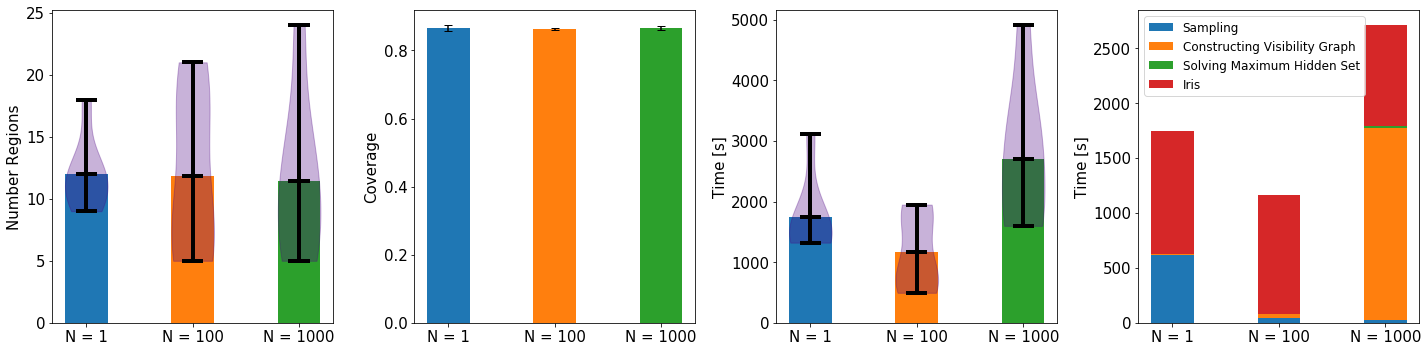

In [35]:
import matplotlib.pyplot as plt

# Sample data for three approaches and three phases
approaches = ['N = 1', 'N = 100', 'N = 1000']
# phases = ['Phase 1', 'Phase 2', 'Phase 3']

# approach1_times = [10, 15, 5]  # Time contributions for Approach 1
# approach2_times = [8, 12, 6]   # Time contributions for Approach 2
# approach3_times = [12, 10, 8]  # Time contributions for Approach 3


# Plotting the bar plot
fig, axs = plt.subplots(ncols = 4, nrows =1, figsize = (20,5))
index = range(len(approaches))
bar_width = 0.4

# ax = axs[0]
# m = []
# min_max = []
# std = []
# for n in [1,100,1000]:
#     exp_arr = np.array(grouped_experiments[1][n])
#     m.append((exp_arr[:, 0]).mean(axis = 0))
#     min_max.append([(exp_arr[:, 0]).min(), (exp_arr[:, 0]).max()]) 
#     std.append((exp_arr[:, 0]).std(axis = 0))
# for i in range(3):
#     ax.bar(index[i],m[i],bar_width)
#     # Plot the error bars
# bounds = np.array(min_max)-np.array(m).reshape(-1,1)
# ax.errorbar(index, m, yerr=[-bounds[:,0], bounds[:,1]], fmt='none', ecolor='k', capsize=3)
# #ax.errorbar(index, m, yerr=std, fmt='none', ecolor='k', capsize=3)

# # Adding labels, titles, and legend
# ax.set_ylabel('Number Regions', fontsize = 15)
# ax.set_xticks([i for i in index])
# ax.set_xticklabels(approaches)
# ax.tick_params(axis='both', which='major', labelsize=15)
# Define the data for the violin plot
data = []
for n in [1, 100, 1000]:
    exp_arr = np.array(grouped_experiments[1][n])
    data.append(exp_arr[:, 0])

# Plotting the bar plot and violin plot
index = range(len(approaches))
bar_width = 0.4

# Bar plot
ax = axs[0]
m = []
min_max = []
std = []
for n in [1, 100, 1000]:
    exp_arr = np.array(grouped_experiments[1][n])
    m.append(exp_arr[:, 0].mean(axis=0))
    min_max.append([exp_arr[:, 0].min(), exp_arr[:, 0].max()])
    std.append(exp_arr[:, 0].std(axis=0))
for i in range(3):
    ax.bar(index[i], m[i], bar_width,zorder =0)

# Plot the error bars
bounds = np.array(min_max) - np.array(m).reshape(-1, 1)
#ax.errorbar(index, m, yerr=[-bounds[:, 0], bounds[:, 1]], fmt='none', ecolor='k', capsize=3)

# Violin plot
vp = ax.violinplot(data, positions=index, widths=bar_width, showmeans=True)
for pc in vp['bodies']:
    pc.set_facecolor('indigo')
    pc.set_edgecolor('indigo')
for key in vp.keys():
    if key!= 'bodies':
        vp[key].set_color('black')
        vp[key].set_linewidth(4)
        
    #pc.set_color('black')
# Adding labels, titles, and legend
axs[0].set_ylabel('Number Regions', fontsize=15)
axs[0].set_xticks([i for i in index])
axs[0].set_xticklabels(approaches)
axs[0].tick_params(axis='both', which='major', labelsize=15)

ax = axs[1]
m = []
min_max = []
std = []
data = []
for n in [1, 100, 1000]:
    exp_arr = np.array(grouped_experiments[1][n])
    data.append(exp_arr[:, 1])

for n in [1,100,1000]:
    exp_arr = np.array(grouped_experiments[1][n])
    m.append((exp_arr[:, 1]).mean(axis = 0))
    min_max.append([(exp_arr[:, 1]).min(), (exp_arr[:, 1]).max()]) 
    std.append((exp_arr[:, 1]).std(axis = 0))
for i in range(3):
    ax.bar(index[i],m[i],bar_width)
    # Plot the error bars
bounds = np.array(min_max)-np.array(m).reshape(-1,1)
#ax.errorbar(index, m, yerr=[-bounds[:,0], bounds[:,1]], fmt='none', ecolor='k', capsize=3)
ax.errorbar(index, m, yerr=std, fmt='none', ecolor='k', capsize=4)
# Violin plot
# vp = ax.violinplot(data, positions=index, widths=bar_width, showmeans=True)
# for pc in vp['bodies']:
#     pc.set_facecolor('indigo')
#     pc.set_edgecolor('indigo')
# for key in vp.keys():
#     if key!= 'bodies':
#         vp[key].set_color('black')
#         vp[key].set_linewidth(4)

# Adding labels, titles, and legend
ax.set_ylabel('Coverage', fontsize = 15)
ax.set_xticks([i for i in index])
ax.set_xticklabels(approaches)
ax.tick_params(axis='both', which='major', labelsize=15)

data = []
for n in [1, 100, 1000]:
    exp_arr = np.array(grouped_experiments[1][n])
    data.append(exp_arr[:, 2])

ax = axs[2]
m = []
min_max = []
std = []
for n in [1,100,1000]:
    exp_arr = np.array(grouped_experiments[1][n])
    m.append((exp_arr[:, 2]).mean(axis = 0))
    min_max.append([(exp_arr[:, 2]).min(), (exp_arr[:, 2]).max()]) 
    std.append((exp_arr[:, 2]).std(axis = 0))
for i in range(3):
    ax.bar(index[i],m[i],bar_width, zorder = 0)
    # Plot the error bars
bounds = np.array(min_max)-np.array(m).reshape(-1,1)
#ax.errorbar(index, m, yerr=[-bounds[:,0], bounds[:,1]], fmt='none', ecolor='k', capsize=3)
#ax.errorbar(index, m, yerr=std, fmt='none', ecolor='k', capsize=3)
# Violin plot
vp = ax.violinplot(data, positions=index, widths=bar_width, showmeans=True)
for pc in vp['bodies']:
    pc.set_facecolor('indigo')
    pc.set_edgecolor('indigo')
for key in vp.keys():
    if key!= 'bodies':
        vp[key].set_color('black')
        vp[key].set_linewidth(4)

# Adding labels, titles, and legend
ax.set_ylabel('Time [s]', fontsize = 15)
ax.set_xticks([i for i in index])
ax.set_xticklabels(approaches)
ax.tick_params(axis='both', which='major', labelsize=15)
# # Adding total time values above each bar
# for i, v in enumerate(total_times):
#     ax.text(i, v + 0.5, str(v), ha='center')
ax = axs[3]
#approaches = ['N = 1', 'N = 40', 'N = 400']
phases = ['Sampling', 'Constructing Visibility Graph', 'Solving Maximum Hidden Set', 'Iris']

approach1_times = (np.array(grouped_experiments[1][1])[:, -4:]).mean(axis = 0)  # Time contributions for Approach 1
approach2_times = (np.array(grouped_experiments[1][100])[:, -4:]).mean(axis = 0)   # Time contributions for Approach 2
approach3_times = (np.array(grouped_experiments[1][1000])[:, -4:]).mean(axis = 0) # Time contributions for Approach 3

# Calculate the cumulative sum for each approach's time contributions
approach1_cumulative = np.cumsum(approach1_times)
approach2_cumulative = np.cumsum(approach2_times)
approach3_cumulative = np.cumsum(approach3_times)

time_data = np.array([approach1_times,approach2_times,approach3_times] )
time_data_cumusum  = np.array([approach1_cumulative,approach2_cumulative,approach3_cumulative] )
# Plotting the stacked bar plot

ax.bar(approaches, time_data[:, 0],bar_width, label=phases[0])
ax.bar(approaches, time_data[:, 1],bar_width, bottom=time_data_cumusum[:, 0], label=phases[1])
ax.bar(approaches, time_data[:, 2],bar_width, bottom=time_data_cumusum[:, 1], label=phases[2])
ax.bar(approaches, time_data[:, 3],bar_width, bottom=time_data_cumusum[:, 2], label=phases[3])
#ax.bar(approaches, approach2_times, bottom=approach1_cumulative, label='Phase 2')
#ax.bar(approaches, approach3_times, bottom=approach2_cumulative, label='Phase 3')

# Adding labels, title, and legend
#ax.set_xlabel('Approaches',)
ax.set_ylabel('Time [s]', fontsize = 15)
#ax.set_title('Average Timing Breakdown', fontsize = 20)
ax.legend(fontsize = 12,loc='upper left' )
ax.tick_params(axis='both', which='major', labelsize=15)



plt.tight_layout()
plt.savefig('5dof_no_shelf_comparison.pdf')
plt.show()

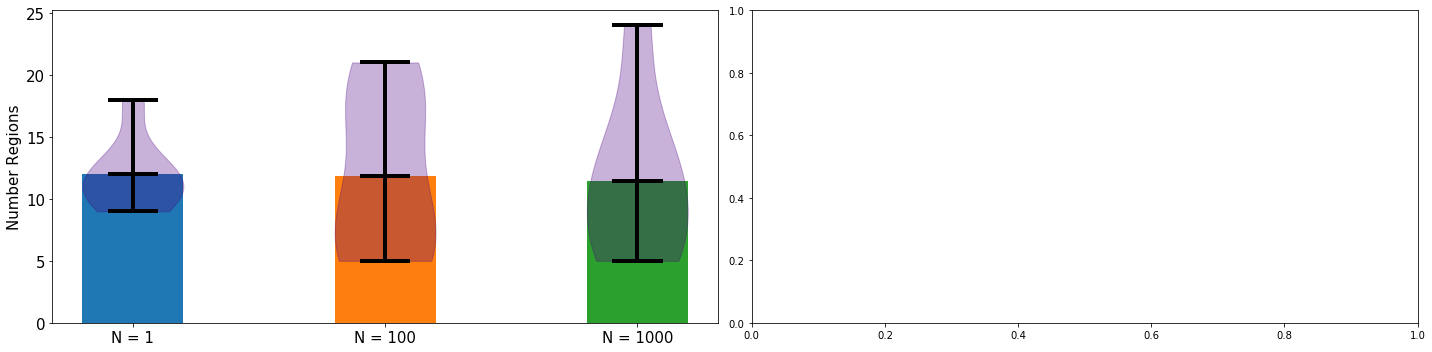

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for the violin plot
data = []
for n in [1, 100, 1000]:
    exp_arr = np.array(grouped_experiments[1][n])
    data.append(exp_arr[:, 0])

# Plotting the bar plot and violin plot
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
index = range(len(approaches))
bar_width = 0.4

# Bar plot
ax = axs[0]
m = []
min_max = []
std = []
for n in [1, 100, 1000]:
    exp_arr = np.array(grouped_experiments[1][n])
    m.append(exp_arr[:, 0].mean(axis=0))
    min_max.append([exp_arr[:, 0].min(), exp_arr[:, 0].max()])
    std.append(exp_arr[:, 0].std(axis=0))
for i in range(3):
    ax.bar(index[i], m[i], bar_width,zorder =0)

# Plot the error bars
bounds = np.array(min_max) - np.array(m).reshape(-1, 1)
#ax.errorbar(index, m, yerr=[-bounds[:, 0], bounds[:, 1]], fmt='none', ecolor='k', capsize=3)

# Violin plot

vp = ax.violinplot(data, positions=index, widths=bar_width, showmeans=True)
for pc in vp['bodies']:
    pc.set_facecolor('indigo')
    pc.set_edgecolor('indigo')
for key in vp.keys():
    if key!= 'bodies':
        vp[key].set_color('black')
        vp[key].set_linewidth(4)
        
    #pc.set_color('black')
# Adding labels, titles, and legend
axs[0].set_ylabel('Number Regions', fontsize=15)
axs[0].set_xticks([i for i in index])
axs[0].set_xticklabels(approaches)
axs[0].tick_params(axis='both', which='major', labelsize=15)


# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
for pc in vp['bodies']:
    pc.set_facecolor('red')
    pc.set_edgecolor('black')

In [25]:
vp

{'bodies': [<matplotlib.collections.PolyCollection at 0x7feed42b1580>,
 'cmeans': <matplotlib.collections.LineCollection at 0x7feed3b137c0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7feed4856880>,
 'cmins': <matplotlib.collections.LineCollection at 0x7feed4856b80>,
 'cbars': <matplotlib.collections.LineCollection at 0x7feed4856e80>}